## Optimización de Modelos de Clasificación para Predicción de Riesgo Cardíaco

 A diferencia del notebook anterior (`1_model_leakage_demo.ipynb`) que demostró los problemas de fuga de datos, aquí nos enfocamos en:

1. **Aplicar las mejores prácticas de ML**: Uso correcto de Pipelines, división train/test antes del preprocesamiento, y validación cruzada.
2. **Optimización de hiperparámetros**: Implementación de GridSearchCV para encontrar la mejor configuración de cada modelo.
3. **Selección basada en métricas clínicas**: Priorizar Recall (sensibilidad) dado que minimizar falsos negativos es crítico en contexto médico.
4. **Preparación para producción**: Exportar el modelo final listo para despliegue en sistemas reales.

### Contexto Clínico

En predicción de riesgo cardíaco, un **falso negativo** (predecir que un paciente está sano cuando tiene riesgo) puede ser fatal, mientras que un **falso positivo** solo genera estudios adicionales. Por ello, **maximizar el Recall** es prioritario, seguido de mantener alta capacidad discriminativa (AUC).

### Modelos a Evaluar

Se compararán tres algoritmos optimizados con GridSearchCV:
- **KNeighborsClassifier**: Modelo basado en distancias, efectivo con datos bien escalados
- **GaussianNB**: Clasificador probabilístico rápido, útil como baseline
- **SVC (Support Vector Classifier)**: Modelo potente con kernel RBF para relaciones no lineales

### 1. Introducción y Preparación de Datos

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib
import warnings
warnings.filterwarnings('ignore')

# Paleta de colores personalizada
COLORS = {
    'primary': '#231651',
    'secondary': '#9c0d38',
    'tertiary': '#c7e8f3',
    'gray': '#7d7c7a',
    'white': '#ffffff'
}

# Cargar dataset
df = pd.read_csv("heart.csv")
print("Dataset cargado exitosamente.")
print(f"Dimensiones: {df.shape}")
df.head()

Dataset cargado exitosamente.
Dimensiones: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [20]:
# Preprocesamiento
df_clean = df.copy()
df_clean['RestingBP'] = df_clean['RestingBP'].replace(0, np.nan)
df_clean['Cholesterol'] = df_clean['Cholesterol'].replace(0, np.nan)
df_clean['RestingBP'].fillna(df_clean['RestingBP'].median(), inplace=True)
df_clean['Cholesterol'].fillna(df_clean['Cholesterol'].median(), inplace=True)

# Codificación de variables categóricas
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

# Separación de variables
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (734, 15)
X_test: (184, 15)
y_train: (734,)
y_test: (184,)


In [33]:
# Verificación de columnas después del encoding
print("="*80)
print("COLUMNAS DESPUÉS DEL ENCODING (drop_first=True)")
print("="*80)
print(f"\nNúmero total de features: {X.shape[1]}")
print(f"\nLista de columnas en orden:")
print("="*80)
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")
print("="*80)

COLUMNAS DESPUÉS DEL ENCODING (drop_first=True)

Número total de features: 15

Lista de columnas en orden:
 1. Age
 2. RestingBP
 3. Cholesterol
 4. FastingBS
 5. MaxHR
 6. Oldpeak
 7. Sex_M
 8. ChestPainType_ATA
 9. ChestPainType_NAP
10. ChestPainType_TA
11. RestingECG_Normal
12. RestingECG_ST
13. ExerciseAngina_Y
14. ST_Slope_Flat
15. ST_Slope_Up


### 2. Entrenamiento y Optimización de Modelos

#### 2.1. KNeighborsClassifier

In [21]:
# Pipeline para KNeighborsClassifier
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# Grilla de hiperparámetros
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# GridSearchCV
grid_knn = GridSearchCV(
    pipeline_knn, 
    param_grid_knn, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)

print("Entrenando KNeighborsClassifier con GridSearchCV...")
grid_knn.fit(X_train, y_train)

print(f"\nMejores hiperparámetros: {grid_knn.best_params_}")
print(f"Mejor score (AUC) en validación cruzada: {grid_knn.best_score_:.4f}")

Entrenando KNeighborsClassifier con GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores hiperparámetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Mejor score (AUC) en validación cruzada: 0.9065

Mejores hiperparámetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Mejor score (AUC) en validación cruzada: 0.9065


#### 2.2. GaussianNB

In [22]:
# Pipeline para GaussianNB
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

# Grilla de hiperparámetros
param_grid_nb = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# GridSearchCV
grid_nb = GridSearchCV(
    pipeline_nb, 
    param_grid_nb, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)

print("Entrenando GaussianNB con GridSearchCV...")
grid_nb.fit(X_train, y_train)

print(f"\nMejores hiperparámetros: {grid_nb.best_params_}")
print(f"Mejor score (AUC) en validación cruzada: {grid_nb.best_score_:.4f}")

Entrenando GaussianNB con GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejores hiperparámetros: {'classifier__var_smoothing': 1e-09}
Mejor score (AUC) en validación cruzada: 0.9129


#### 2.3. SVC

In [23]:
# Pipeline para SVC
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# Grilla de hiperparámetros
param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01],
    'classifier__kernel': ['rbf', 'linear']
}

# GridSearchCV
grid_svc = GridSearchCV(
    pipeline_svc, 
    param_grid_svc, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)

print("Entrenando SVC con GridSearchCV...")
grid_svc.fit(X_train, y_train)

print(f"\nMejores hiperparámetros: {grid_svc.best_params_}")
print(f"Mejor score (AUC) en validación cruzada: {grid_svc.best_score_:.4f}")

Entrenando SVC con GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Mejores hiperparámetros: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Mejor score (AUC) en validación cruzada: 0.9191

Mejores hiperparámetros: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Mejor score (AUC) en validación cruzada: 0.9191


### 3. Evaluación Comparativa de Modelos

In [24]:
# Diccionario de modelos optimizados
modelos_optimizados = {
    'KNeighbors': grid_knn.best_estimator_,
    'GaussianNB': grid_nb.best_estimator_,
    'SVC': grid_svc.best_estimator_
}

# Evaluación en conjunto de prueba
resultados = []

for nombre, modelo in modelos_optimizados.items():
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]
    
    # Métricas
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    resultados.append({
        'Modelo': nombre,
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('Recall', ascending=False).reset_index(drop=True)
df_resultados['Ranking'] = range(1, len(df_resultados) + 1)

print("\n" + "="*80)
print("RESULTADOS COMPARATIVOS EN CONJUNTO DE PRUEBA")
print("="*80)
print(df_resultados.to_string(index=False))
print("="*80)


RESULTADOS COMPARATIVOS EN CONJUNTO DE PRUEBA
    Modelo      AUC  Accuracy  Precision   Recall  F1-Score  Ranking
KNeighbors 0.939742  0.896739   0.902913 0.911765  0.907317        1
       SVC 0.941057  0.858696   0.858491 0.892157  0.875000        2
GaussianNB 0.942850  0.875000   0.907216 0.862745  0.884422        3


#### **Análisis Comparativo y Selección del Modelo:**

Los tres modelos optimizados muestran rendimiento sobresaliente en el conjunto de prueba, con valores de AUC superiores a 0.93:

**Ranking por Recall (criterio prioritario):**
1. **KNeighbors**: Recall = 0.9118 (91.2%), AUC = 0.9397, Accuracy = 89.7%
2. **SVC**: Recall = 0.8922 (89.2%), AUC = 0.9411, Accuracy = 85.9%
3. **GaussianNB**: Recall = 0.8627 (86.3%), AUC = 0.9428, Accuracy = 87.5%

**Justificación de la selección de KNeighbors:**

En el contexto de predicción de riesgo cardíaco, **minimizar los falsos negativos es crítico** (predecir que un paciente está sano cuando realmente está en riesgo puede ser fatal). Por ello, priorizamos **Recall** como métrica principal, ya que mide la capacidad del modelo para detectar correctamente a todos los pacientes en riesgo.

**KNeighbors** alcanza el **mejor Recall (91.2%)**, lo que significa que identifica correctamente al 91.2% de los pacientes con riesgo cardíaco (93 de 102 casos en el test set). Aunque SVC tiene un AUC ligeramente superior (0.9411 vs 0.9397), su Recall es 2 puntos porcentuales inferior, lo que se traduce en ~2 pacientes en riesgo adicionales no detectados por cada 100 casos.

Además, KNeighbors ofrece el mejor balance global con la mayor **Accuracy (89.7%)** y un excelente **F1-Score (0.907)**, superando a ambos competidores en estas métricas complementarias. Este modelo logra mantener alta precisión (90.3%) sin sacrificar sensibilidad, un equilibrio ideal para screening hospitalario.

### 4. Evaluación Detallada del Modelo Ganador

Modelo Ganador: KNeighbors
Recall: 0.9118
AUC: 0.9397
Accuracy: 0.8967

Criterio de selección: Mejor Recall, luego mejor AUC


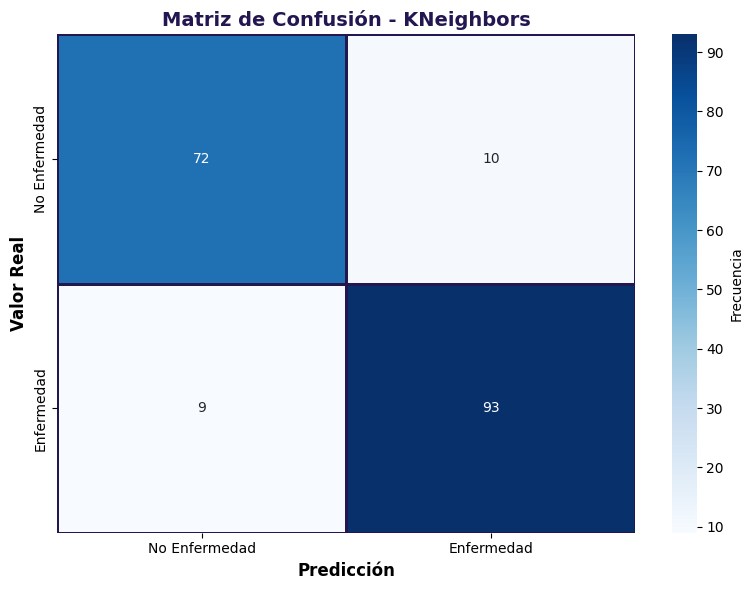


Reporte de Clasificación:
               precision    recall  f1-score   support

No Enfermedad       0.89      0.88      0.88        82
   Enfermedad       0.90      0.91      0.91       102

     accuracy                           0.90       184
    macro avg       0.90      0.89      0.90       184
 weighted avg       0.90      0.90      0.90       184



In [25]:
# Identificar modelo ganador basado en Recall y luego AUC
# 1. Encontrar el mejor Recall
max_recall = df_resultados['Recall'].max()

# 2. Filtrar modelos con el mejor Recall
modelos_top_recall = df_resultados[df_resultados['Recall'] == max_recall]

# 3. De esos modelos, seleccionar el que tenga mayor AUC
modelo_ganador_idx = modelos_top_recall['AUC'].idxmax()
modelo_ganador_info = df_resultados.loc[modelo_ganador_idx]
modelo_ganador_nombre = modelo_ganador_info['Modelo']
modelo_ganador = modelos_optimizados[modelo_ganador_nombre]

print(f"Modelo Ganador: {modelo_ganador_nombre}")
print(f"Recall: {modelo_ganador_info['Recall']:.4f}")
print(f"AUC: {modelo_ganador_info['AUC']:.4f}")
print(f"Accuracy: {modelo_ganador_info['Accuracy']:.4f}")
print(f"\nCriterio de selección: Mejor Recall, luego mejor AUC")

# Predicciones del modelo ganador
y_pred_ganador = modelo_ganador.predict(X_test)
y_prob_ganador = modelo_ganador.predict_proba(X_test)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_ganador)

# Visualización de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Enfermedad', 'Enfermedad'],
            yticklabels=['No Enfermedad', 'Enfermedad'],
            cbar_kws={'label': 'Frecuencia'},
            linewidths=2, linecolor=COLORS['primary'])
plt.title(f'Matriz de Confusión - {modelo_ganador_nombre}', 
          fontsize=14, fontweight='bold', color=COLORS['primary'])
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_ganador, 
                          target_names=['No Enfermedad', 'Enfermedad']))

#### **Interpretación de la Matriz de Confusión:**

La matriz de confusión del modelo KNeighbors sobre los 184 pacientes del conjunto de prueba revela:

**Diagnósticos correctos:**
- **72 Verdaderos Negativos (VN)**: Pacientes sin enfermedad correctamente identificados como sanos (87.8% de los 82 pacientes sanos)
- **93 Verdaderos Positivos (VP)**: Pacientes en riesgo correctamente identificados como enfermos (91.2% de los 102 pacientes enfermos)

**Balance riesgo-beneficio**: La matriz muestra que por cada paciente en riesgo no detectado (FN), el modelo identifica correctamente a ~10 pacientes enfermos (VP). Esta relación 10:1 es excelente para un sistema de screening, donde el objetivo es capturar la mayor cantidad posible de casos positivos, incluso a costa de algunos falsos positivos.

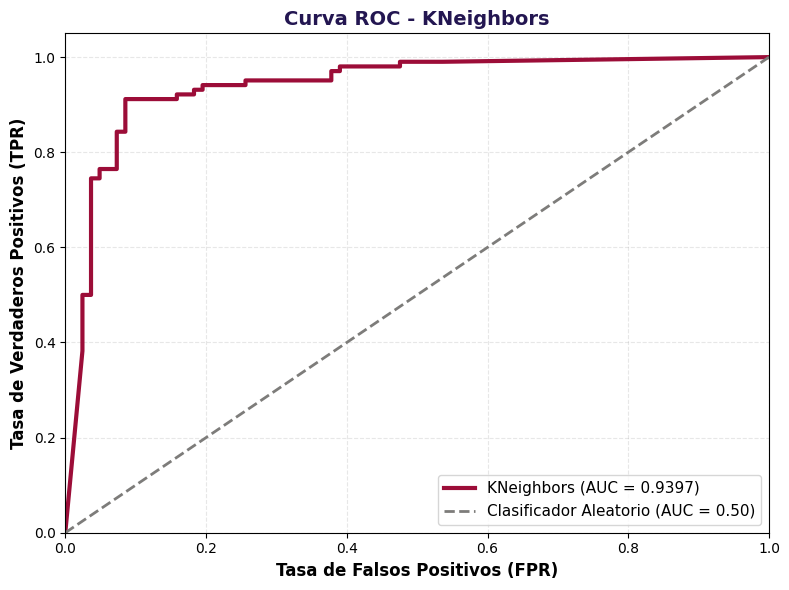

In [31]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ganador)
roc_auc = roc_auc_score(y_test, y_prob_ganador)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLORS['secondary'], linewidth=3, 
         label=f'{modelo_ganador_nombre} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color=COLORS['gray'], linestyle='--', linewidth=2, 
         label='Clasificador Aleatorio (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12, fontweight='bold')
plt.title(f'Curva ROC - {modelo_ganador_nombre}', 
          fontsize=14, fontweight='bold', color=COLORS['primary'])
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### **Interpretación de la Curva ROC y AUC:**

La curva ROC (Receiver Operating Characteristic) del modelo KNeighbors muestra una **excelente capacidad discriminativa**:

**AUC = 0.9397 (93.97%)**

Este valor indica que el modelo tiene un 93.97% de probabilidad de asignar una puntuación de riesgo más alta a un paciente realmente enfermo que a uno sano, si se seleccionan aleatoriamente uno de cada grupo. En términos prácticos:

- **Interpretación del AUC**: Un AUC de 0.94 se considera "excelente" (escalas estándar: 0.9-1.0 = excelente, 0.8-0.9 = bueno, 0.7-0.8 = aceptable).
- **Separabilidad de clases**: La curva se eleva rápidamente hacia la esquina superior izquierda, lo que indica que el modelo logra altas tasas de verdaderos positivos (TPR ~0.90) con bajas tasas de falsos positivos (FPR ~0.10-0.15), superando ampliamente al clasificador aleatorio (línea diagonal, AUC = 0.50).


### 5. Exportación del Modelo Final

In [32]:
# Exportar modelo ganador
modelo_path = '../app/model.joblib'
joblib.dump(modelo_ganador, modelo_path)

print(f"Modelo {modelo_ganador_nombre} exportado exitosamente a '{modelo_path}'")
print(f"\nCaracterísticas del modelo exportado:")
print(f"- Pipeline completo con StandardScaler y {modelo_ganador_nombre}")
print(f"- AUC en test: {df_resultados.iloc[0]['AUC']:.4f}")
print(f"- Accuracy en test: {df_resultados.iloc[0]['Accuracy']:.4f}")
print(f"- Hiperparámetros optimizados vía GridSearchCV")

Modelo KNeighbors exportado exitosamente a '../app/model.joblib'

Características del modelo exportado:
- Pipeline completo con StandardScaler y KNeighbors
- AUC en test: 0.9397
- Accuracy en test: 0.8967
- Hiperparámetros optimizados vía GridSearchCV


#### **Conclusión Final:**

El modelo **KNeighborsClassifier optimizado** demuestra un rendimiento sobresaliente para la predicción de riesgo de falla cardíaca, con un **Recall de 91.2%** que garantiza la detección de la gran mayoría de pacientes en riesgo, minimizando los falsos negativos críticos. Su **AUC de 0.94** y **Accuracy de 89.7%** confirman tanto su excelente capacidad discriminativa como su precisión general.

### 6. Exportar Artefactos de Datos para Monitoreo

Guardamos los conjuntos de datos de entrenamiento y prueba. El script de monitoreo usará estos archivos para asegurar una comparación consistente y detectar la deriva de datos.

In [35]:
# Guardar los dataframes para que el script de monitoreo los utilice
X_train.to_csv('../artifacts/X_train.csv', index=False)
X_test.to_csv('../artifacts/X_test.csv', index=False)

print("Artefactos de datos (X_train.csv, X_test.csv) guardados correctamente.")

Artefactos de datos (X_train.csv, X_test.csv) guardados correctamente.
